# Project 2: The Ames Housing Data and House Price Prediction Part 2
## By Evan Jacobs, data genius

All the same steps will be taken as in part 1, sans the markdown cells. Any markdown cells here will be used to describe what is different this time around.

In [54]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split



sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [55]:
train_csv = '/Users/evanjacobs/dsi/DSI-US-4/project-2/train.csv'
test_csv = '/Users/evanjacobs/dsi/DSI-US-4/project-2/test.csv'

In [56]:
df = pd.read_csv(train_csv)
finaltest = pd.read_csv(test_csv)

In [57]:
X = df.drop(['SalePrice'], axis=1)
y = df.SalePrice.values
X_full = df.drop(['SalePrice'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [62]:
def colclean(column_list): 
    columns=[]
    for n in column_list:
        n = n.lower().replace(' ','')
        columns.append(n)
    return columns
colclean(df.columns)
X_train.columns = colclean(X_train.columns)
X_test.columns = colclean(X_test.columns)
X_full.columns = colclean(X_full.columns)
finaltest.columns = colclean(finaltest.columns)

In [67]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
X_full = X_full.fillna(X_full.mean())
finaltest = finaltest.fillna(finaltest.mean())

In [70]:
X_tr_obj = X_train.select_dtypes(exclude=[np.number])
X_tr_num = X_train.select_dtypes(include=[np.number])
X_ts_obj = X_test.select_dtypes(exclude=[np.number])
X_ts_num = X_test.select_dtypes(include=[np.number])
X_full_obj = X_full.select_dtypes(exclude=[np.number])
X_full_num = X_full.select_dtypes(include=[np.number])
finaltest_obj = finaltest.select_dtypes(exclude=[np.number])
finaltest_num = finaltest.select_dtypes(include=[np.number])

We're going to make some dummy columns, but first we have to include mssubclass, which has numerical values but is actually a categorical column. 

In [73]:
X_tr_obj['mssubclass'] = X_tr_num['mssubclass']
X_full_obj['mssubclass'] = X_full_num['mssubclass']
X_ts_obj['mssubclass'] = X_ts_num['mssubclass']
finaltest_obj['mssubclass'] = finaltest_num['mssubclass']

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Dropping mssubclass from our numerical set. 

In [75]:
X_tr_num.drop(['mssubclass'], axis = 1, inplace=True)
X_full_num.drop(['mssubclass'], axis = 1, inplace=True)
X_ts_num.drop(['mssubclass'], axis = 1, inplace=True)
finaltest_num.drop(['mssubclass'], axis = 1, inplace=True)

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/envs/dsi/lib/python3.6/site-pa

The null values in the object columns tend to be assigned to a null case, so filling them with zeroes will allow get_dummies to be ran on them, creating a new column for these zero values and assigning a 1 to any row that had a null value. There are probably other, easier ways of doing this.

In [76]:
def quickfill(x):
    x.fillna(0, inplace=True)
quickfill(X_tr_obj)
quickfill(X_full_obj)
quickfill(X_ts_obj)
quickfill(finaltest_obj)

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Here we concatenate our train and test set to run dummies on both at once so we can ensure both sets have the same number of columns. I've heard this causes data leakage, but I'm not really sure how. If I hadn't done this, I could have painstakingly figured out which columns were missing and add them myself, but I don't fully understand how to do that and the process would have taken hours. Finally, we combine our object columns with our numerical columns.

In [77]:
temp_set = pd.concat([X_tr_obj, X_ts_obj], axis=0)
temp_set = pd.get_dummies(temp_set, columns=temp_set.columns, drop_first=True)
X_tr_dum1 = temp_set[:len(X_tr_obj)]
X_ts_dum1 = temp_set[len(X_tr_obj):]
X_train = pd.concat([X_tr_num, X_tr_dum1], axis = 1)
X_test = pd.concat([X_ts_num, X_ts_dum1], axis = 1)



X_full = pd.concat([X_full_num, pd.get_dummies(X_full_obj, columns=X_full_obj, drop_first=True)], axis=1)
finaltest = pd.concat([finaltest_num, pd.get_dummies(finaltest_obj, columns=finaltest_obj, drop_first=True)], axis=1)

In [78]:
X_train['sp']=y_train

Using our samem technique of choosing a threshhold for correlation. Everything after this will be the same as in part 1. 

In [80]:
vals = abs(X_train.corr().sp).drop('sp').sort_values(ascending=False)
corr_cols = list(vals[vals >= .4].index)

In [81]:
X_train = X_train.drop(['sp'], axis=1)

In [82]:
X_tr_mod2 = X_train[corr_cols]
X_ts_mod2 = X_test[corr_cols]
X_full_mod2 = X_full[corr_cols]
finaltest_mod2 = finaltest[corr_cols]

In [83]:
finaltest_mod2.isna().sum()[finaltest_mod2.isna().sum() !=0]

Series([], dtype: int64)

In [84]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=True, 
                         include_bias=False)
pf.fit(X_tr_mod2)
X_tr_mod2 = pf.transform(X_tr_mod2)
X_ts_mod2 = pf.transform(X_ts_mod2)
X_full_mod2 = pf.transform(X_full_mod2)
finaltest_mod2 = pf.transform(finaltest_mod2)

In [85]:
X_tr_mod2.shape

(1538, 325)

In [86]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_tr_mod2 = ss.fit_transform(X_tr_mod2)
X_ts_mod2 = ss.transform(X_ts_mod2)
X_full_mod2 = ss.fit_transform(X_full_mod2)
finaltest_mod2 = ss.transform(finaltest_mod2)

In [87]:
l_alphas = np.arange(.001, .15, .0025)
lasso_model = LassoCV(alphas=l_alphas, max_iter=2000, cv=5)
# lasso_model = LassoCV(max_iter=10000, cv=5)
model_2 = lasso_model.fit(X_tr_mod2, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [88]:
print(model_2.score(X_ts_mod2, y_test))

0.8518331984922041


In [89]:
ridge_alphas = np.logspace(0, 5, 200)

ridge_model = RidgeCV(alphas=ridge_alphas, cv=10)
# ridge_model = RidgeCV(cv=10)
ridge_model.fit(X_tr_mod2, y_train)

RidgeCV(alphas=array([1.00000e+00, 1.05956e+00, ..., 9.43788e+04, 1.00000e+05]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [90]:
ridge = Ridge(alpha=ridge_model.alpha_)

ridge_scores = cross_val_score(ridge, X_ts_mod2, y_test, cv=15)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.94795497 0.82150053 0.88847613 0.92143742 0.85591046 0.9274677
 0.80318811 0.92177977 0.91997141 0.82559994 0.92253742 0.92254717
 0.8604093  0.74572288 0.86640018]
0.8767268931704294


In [91]:
l1_ratios = np.linspace(0.01, 1.0, 25)

enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, max_iter=10000, cv=10,
                            verbose=0)
enet.fit(X_tr_mod2, y_train)

print(enet.alpha_)
print(enet.l1_ratio_)


109.63345295366942
1.0


In [92]:
enet = ElasticNet(alpha=enet.alpha_, l1_ratio=enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_ts_mod2, y_test, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

[0.89932097 0.84091643 0.89635179 0.89001743 0.83820384 0.90713471
 0.82976472 0.91587491 0.74145978 0.83904867]
0.859809325265339


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


So here it seems we're getting slightly better scores on average, probably because we've included more information in the form of our dummy variables. Our scores are similar to our part 1 scores, but I think with a little more patience and a few more models, we could get far better scores with this set. 

In [ ]:
# l1_ratios = np.linspace(0.01, 1.0, 25)

# model_2_final = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
#                             verbose=0)

# print(model_2_final.alpha_)
# print(model_2_final.l1_ratio_)

l_alphas = np.arange(.001, .15, .0025)
lasso_model = LassoCV(alphas=l_alphas, max_iter=2000, cv=5)
# lasso_model = LassoCV(max_iter=10000, cv=5)
model_2_final = lasso_model.fit(X_tr_mod2, y_train)



model_2_final.fit(X_full_mod2, y)

Sending to kagggle. That's model 2!

In [53]:
evansubmission2 = pd.DataFrame(data = model_2_final.predict(finaltest_mod2), columns = ['SalePrice'], index=finaltest['id'])
evansubmission2.to_csv('./evansubmission2.csv')

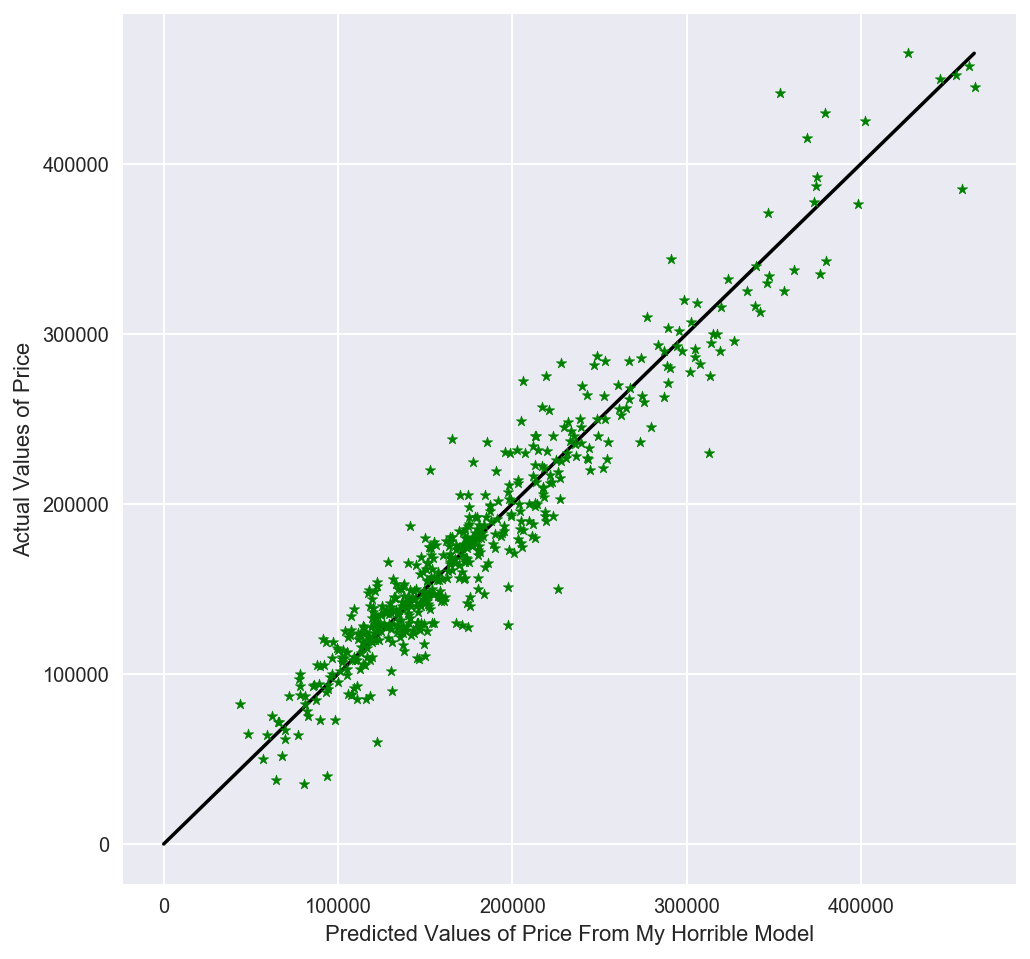

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [94]:
predictions = model_2_final.predict(X_ts_mod2)
y = y_test

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='g', marker='*', zorder=10)
plt.xlabel("Predicted Values of Price From My Horrible Model")
plt.ylabel("Actual Values of Price")

plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k')

plt.show()
score = cross_val_score(model_2_final, X_ts_mod2, y_test, cv=10)
print("score: ", score.mean())

In [56]:
# There are three files:

# train.csv -- this data contains all of the training data for your model.
# The target variable (SalePrice) is removed from the test set!
# test.csv -- this data contains the test data for your model. You will feed this data into your regression model to make predictions.
# sample_sub_reg.csv -- An example of a correctly formatted submission for this challenge (with a random number provided as predictions for SalePrice. Please ensure that your submission to Kaggle matches this format.
# Codebook / Data Dictionary:

# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict for this challenge.
# MSSubClass: The building class
#     20 1-STORY 1946 & NEWER ALL STYLES
#     30 1-STORY 1945 & OLDER
#     40 1-STORY W/FINISHED ATTIC ALL AGES
#     45 1-1/2 STORY - UNFINISHED ALL AGES
#     50 1-1/2 STORY FINISHED ALL AGES
#     60 2-STORY 1946 & NEWER
#     70 2-STORY 1945 & OLDER
#     75 2-1/2 STORY ALL AGES
#     80 SPLIT OR MULTI-LEVEL
#     85 SPLIT FOYER
#     90 DUPLEX - ALL STYLES AND AGES
#     120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#     150 1-1/2 STORY PUD - ALL AGES
#     160 2-STORY PUD - 1946 & NEWER
#     180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#     190 2 FAMILY CONVERSION - ALL STYLES AND AGES
# MSZoning: Identifies the general zoning classification of the sale.
#     A Agriculture
#     C Commercial
#     FV Floating Village Residential
#     I Industrial
#     RH Residential High Density
#     RL Residential Low Density
#     RP Residential Low Density Park
#     RM Residential Medium Density
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# Street: Type of road access to property
#     Grvl Gravel
#     Pave Paved
# Alley: Type of alley access to property
#     Grvl Gravel
#     Pave Paved
#     NA No alley access
# LotShape: General shape of property
#     Reg Regular
#     IR1 Slightly irregular
#     IR2 Moderately Irregular
#     IR3 Irregular
# LandContour: Flatness of the property
#     Lvl Near Flat/Level
#     Bnk Banked - Quick and significant rise from street grade to building
#     HLS Hillside - Significant slope from side to side
#     Low Depression
# Utilities: Type of utilities available
#     AllPub All public Utilities (E,G,W,& S)
#     NoSewr Electricity, Gas, and Water (Septic Tank)
#     NoSeWa Electricity and Gas Only
#     ELO Electricity only
# LotConfig: Lot configuration
#     Inside Inside lot
#     Corner Corner lot
#     CulDSac Cul-de-sac
#     FR2 Frontage on 2 sides of property
#     FR3 Frontage on 3 sides of property
# LandSlope: Slope of property
#     Gtl Gentle slope
#     Mod Moderate Slope
#     Sev Severe Slope
# Neighborhood: Physical locations within Ames city limits
#     Blmngtn Bloomington Heights
#     Blueste Bluestem
#     BrDale Briardale
#     BrkSide Brookside
#     ClearCr Clear Creek
#     CollgCr College Creek
#     Crawfor Crawford
#     Edwards Edwards
#     Gilbert Gilbert
#     IDOTRR Iowa DOT and Rail Road
#     MeadowV Meadow Village
#     Mitchel Mitchell
#     Names North Ames
#     NoRidge Northridge
#     NPkVill Northpark Villa
#     NridgHt Northridge Heights
#     NWAmes Northwest Ames
#     OldTown Old Town
#     SWISU South & West of Iowa State University
#     Sawyer Sawyer
#     SawyerW Sawyer West
#     Somerst Somerset
#     StoneBr Stone Brook
#     Timber Timberland
#     Veenker Veenker
# Condition1: Proximity to main road or railroad
#     Artery Adjacent to arterial street
#     Feedr Adjacent to feeder street
#     Norm Normal
#     RRNn Within 200' of North-South Railroad
#     RRAn Adjacent to North-South Railroad
#     PosN Near positive off-site feature--park, greenbelt, etc.
#     PosA Adjacent to postive off-site feature
#     RRNe Within 200' of East-West Railroad
#     RRAe Adjacent to East-West Railroad
# Condition2: Proximity to main road or railroad (if a second is present)
#     Artery Adjacent to arterial street
#     Feedr Adjacent to feeder street
#     Norm Normal
#     RRNn Within 200' of North-South Railroad
#     RRAn Adjacent to North-South Railroad
#     PosN Near positive off-site feature--park, greenbelt, etc.
#     PosA Adjacent to postive off-site feature
#     RRNe Within 200' of East-West Railroad
#     RRAe Adjacent to East-West Railroad
# BldgType: Type of dwelling
#     1Fam Single-family Detached
#     2FmCon Two-family Conversion; originally built as one-family dwelling
#     Duplx Duplex
#     TwnhsE Townhouse End Unit
#     TwnhsI Townhouse Inside Unit
# HouseStyle: Style of dwelling
#     1Story One story
#     1.5Fin One and one-half story: 2nd level finished
#     1.5Unf One and one-half story: 2nd level unfinished
#     2Story Two story
#     2.5Fin Two and one-half story: 2nd level finished
#     2.5Unf Two and one-half story: 2nd level unfinished
#     SFoyer Split Foyer
#     SLvl Split Level
# OverallQual: Overall material and finish quality
#     10 Very Excellent
#     9 Excellent
#     8 Very Good
#     7 Good
#     6 Above Average
#     5 Average
#     4 Below Average
#     3 Fair
#     2 Poor
#     1 Very Poor
# OverallCond: Overall condition rating
#     10 Very Excellent
#     9 Excellent
#     8 Very Good
#     7 Good
#     6 Above Average
#     5 Average
#     4 Below Average
#     3 Fair
#     2 Poor
#     1 Very Poor
# YearBuilt: Original construction date
# YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
# RoofStyle: Type of roof
#     Flat Flat
#     Gable Gable
#     Gambrel Gabrel (Barn)
#     Hip Hip
#     Mansard Mansard
#     Shed Shed
# RoofMatl: Roof material
#     ClyTile Clay or Tile
#     CompShg Standard (Composite) Shingle
#     Membran Membrane
#     Metal Metal
#     Roll Roll
#     Tar&Grv Gravel & Tar
#     WdShake Wood Shakes
#     WdShngl Wood Shingles
# Exterior1st: Exterior covering on house
#     AsbShng Asbestos Shingles
#     AsphShn Asphalt Shingles
#     BrkComm Brick Common
#     BrkFace Brick Face
#     CBlock Cinder Block
#     CemntBd Cement Board
#     HdBoard Hard Board
#     ImStucc Imitation Stucco
#     MetalSd Metal Siding
#     Other Other
#     Plywood Plywood
#     PreCast PreCast
#     Stone Stone
#     Stucco Stucco
#     VinylSd Vinyl Siding
#     Wd Sdng Wood Siding
#     WdShing Wood Shingles
# Exterior2nd: Exterior covering on house (if more than one material)
#     AsbShng Asbestos Shingles
#     AsphShn Asphalt Shingles
#     BrkComm Brick Common
#     BrkFace Brick Face
#     CBlock Cinder Block
#     CemntBd Cement Board
#     HdBoard Hard Board
#     ImStucc Imitation Stucco
#     MetalSd Metal Siding
#     Other Other
#     Plywood Plywood
#     PreCast PreCast
#     Stone Stone
#     Stucco Stucco
#     VinylSd Vinyl Siding
#     Wd Sdng Wood Siding
#     WdShing Wood Shingles
# MasVnrType: Masonry veneer type
#     BrkCmn Brick Common
#     BrkFace Brick Face
#     CBlock Cinder Block
#     None None
#     Stone Stone
# MasVnrArea: Masonry veneer area in square feet
# ExterQual: Exterior material quality
#     Ex Excellent
#     Gd Good
#     TA Average/Typical
#     Fa Fair
#     Po Poor
# ExterCond: Present condition of the material on the exterior
#     Ex Excellent
#     Gd Good
#     TA Average/Typical
#     Fa Fair
#     Po Poor
# Foundation: Type of foundation
#     BrkTil Brick & Tile
#     CBlock Cinder Block
#     PConc Poured Contrete
#     Slab Slab
#     Stone Stone
#     Wood Wood
# BsmtQual: Height of the basement
#     Ex Excellent (100+ inches)
#     Gd Good (90-99 inches)
#     TA Typical (80-89 inches)
#     Fa Fair (70-79 inches)
#     Po Poor (<70 inches)
#     NA No Basement
# BsmtCond: General condition of the basement
#     Ex Excellent
#     Gd Good
#     TA Typical - slight dampness allowed
#     Fa Fair - dampness or some cracking or settling
#     Po Poor - Severe cracking, settling, or wetness
#     NA No Basement
# BsmtExposure: Walkout or garden level basement walls
#     Gd Good Exposure
#     Av Average Exposure (split levels or foyers typically score average or above)
#     Mn Mimimum Exposure
#     No No Exposure
#     NA No Basement
# BsmtFinType1: Quality of basement finished area
#     GLQ Good Living Quarters
#     ALQ Average Living Quarters
#     BLQ Below Average Living Quarters
#     Rec Average Rec Room
#     LwQ Low Quality
#     Unf Unfinshed
#     NA No Basement
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinType2: Quality of second finished area (if present)
#     GLQ Good Living Quarters
#     ALQ Average Living Quarters
#     BLQ Below Average Living Quarters
#     Rec Average Rec Room
#     LwQ Low Quality
#     Unf Unfinshed
#     NA No Basement
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# Heating: Type of heating
#     Floor Floor Furnace
#     GasA Gas forced warm air furnace
#     GasW Gas hot water or steam heat
#     Grav Gravity furnace
#     OthW Hot water or steam heat other than gas
#     Wall Wall furnace
# HeatingQC: Heating quality and condition
#     Ex Excellent
#     Gd Good
#     TA Average/Typical
#     Fa Fair
#     Po Poor
# CentralAir: Central air conditioning
#     N No
#     Y Yes
# Electrical: Electrical system
#     SBrkr Standard Circuit Breakers & Romex
#     FuseA Fuse Box over 60 AMP and all Romex wiring (Average)
#     FuseF 60 AMP Fuse Box and mostly Romex wiring (Fair)
#     FuseP 60 AMP Fuse Box and mostly knob & tube wiring (poor)
#     Mix Mixed
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Number of bedrooms above basement level
# Kitchen: Number of kitchens
# KitchenQual: Kitchen quality
#     Ex Excellent
#     Gd Good
#     TA Typical/Average
#     Fa Fair
#     Po Poor
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Functional: Home functionality rating
#     Typ Typical Functionality
#     Min1 Minor Deductions 1
#     Min2 Minor Deductions 2
#     Mod Moderate Deductions
#     Maj1 Major Deductions 1
#     Maj2 Major Deductions 2
#     Sev Severely Damaged
#     Sal Salvage only
# Fireplaces: Number of fireplaces
# FireplaceQu: Fireplace quality
#     Ex Excellent - Exceptional Masonry Fireplace
#     Gd Good - Masonry Fireplace in main level
#     TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#     Fa Fair - Prefabricated Fireplace in basement
#     Po Poor - Ben Franklin Stove
#     NA No Fireplace
# GarageType: Garage location
#     2Types More than one type of garage
#     Attchd Attached to home
#     Basment Basement Garage
#     BuiltIn Built-In (Garage part of house - typically has room above garage)
#     CarPort Car Port
#     Detchd Detached from home
#     NA No Garage
# GarageYrBlt: Year garage was built
# GarageFinish: Interior finish of the garage
#     Fin Finished
#     RFn Rough Finished
#     Unf Unfinished
#     NA No Garage
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# GarageQual: Garage quality
#     Ex Excellent
#     Gd Good
#     TA Typical/Average
#     Fa Fair
#     Po Poor
#     NA No Garage
#     GarageCond: Garage condition
#     Ex Excellent
#     Gd Good
#     TA Typical/Average
#     Fa Fair
#     Po Poor
#     NA No Garage
# PavedDrive: Paved driveway
#     Y Paved
#     P Partial Pavement
#     N Dirt/Gravel
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# PoolQC: Pool quality
#     Ex Excellent
#     Gd Good
#     TA Average/Typical
#     Fa Fair
#     NA No Pool
# Fence: Fence quality
#     GdPrv Good Privacy
#     MnPrv Minimum Privacy
#     GdWo Good Wood
#     MnWw Minimum Wood/Wire
#     NA No Fence
# MiscFeature: Miscellaneous feature not covered in other categories
#     Elev Elevator
#     Gar2 2nd Garage (if not described in garage section)
#     Othr Other
#     Shed Shed (over 100 SF)
#     TenC Tennis Court
#     NA None
# MiscVal: $Value of miscellaneous feature
# MoSold: Month Sold
# YrSold: Year Sold
# SaleType: Type of sale
#     WD Warranty Deed - Conventional
#     CWD Warranty Deed - Cash
#     VWD Warranty Deed - VA Loan
#     New Home just constructed and sold
#     COD Court Officer Deed/Estate
#     Con Contract 15% Down payment regular terms
#     ConLw Contract Low Down payment and low interest
#     ConLI Contract Low Interest
#     ConLD Contract Low Down
#     Oth Other
